In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

data = pd.read_csv("terror.csv",encoding='ISO-8859-1')
data = data[["iyear","imonth","iday","country","country_txt","extended","region",
            "region_txt","provstate","summary","success","suicide","attacktype1","attacktype1_txt"
            ,"targtype1","targtype1_txt","natlty1","gname","weaptype1","weaptype1_txt","nkill","nwound"
           ]]

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data["weaptype1_txt"].unique()

array(['Unknown', 'Explosives', 'Incendiary', 'Firearms', 'Chemical',
       'Melee', 'Sabotage Equipment',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'Fake Weapons', 'Radiological', 'Other', 'Biological'],
      dtype=object)

In [3]:
data = data.dropna(axis=0, subset=['summary',"provstate","nwound"])
data = data.drop_duplicates(subset=["summary"])
data.reset_index(inplace=True,drop=True)
data = data[data["iyear"] > 1990]


{'whiskers': [<matplotlib.lines.Line2D at 0x1ef66048898>,
 'caps': [<matplotlib.lines.Line2D at 0x1ef66046400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ef66048a90>],
 'medians': [<matplotlib.lines.Line2D at 0x1ef66046908>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ef65fb0e80>],
 'means': []}

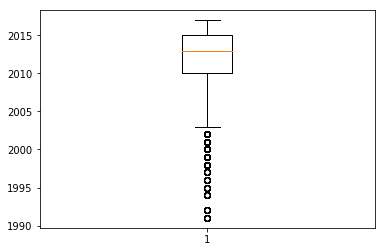

In [4]:
plt.boxplot(data["iyear"])

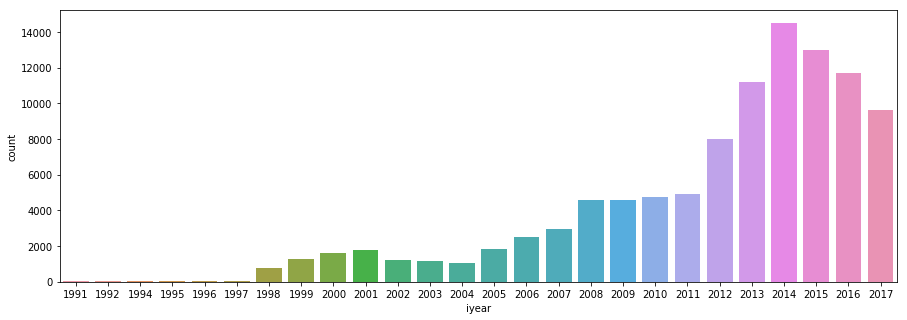

In [5]:
fig = plt.figure(figsize = (15,5))
fig = sns.countplot(data["iyear"])
plt.show()

In [6]:
country = data["country_txt"].value_counts() 
country = country[country >40]

In [7]:
data["no_punct"] = data['summary'].str.replace('[^\w\s]','')

from nltk.corpus import stopwords
stop = stopwords.words('english')

data["modded"] = data['summary'].apply(lambda x: [item.lower() for item in x.split() if item not in stop])


In [8]:
summaries = [el[1:] for el in data["modded"]]

In [9]:
import string 

words = dict()
for element in summaries:
    for s in element:
#        s = s.translate(str.maketrans('', '', string.punctuation))
        if s in words:
            words[s] += 1
        else:
            words[s] = 1

In [10]:
counts = [(x,y) for x,y in words.items()]

counts = sorted(counts,key=lambda x:x[1],reverse= True)
print(len(counts))

pruned_counts = [(x,y) for x,y in counts if y > 5]
print(len(pruned_counts))

116783
16925


In [11]:
pruned_summaries = []
d = dict(pruned_counts)

for el in summaries:
    temp = []
    for s in el: 
        if s in d.keys():
            temp.append(s)
    pruned_summaries.append(temp)


In [12]:
pruned_strings = [' '.join(x for x in element) for element in pruned_summaries]
 

ora devi trovare il modo di usare ste cose per predire il tipo di attacco da quello che c'è scritto nella descrizione

In [13]:
import gensim 
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, LdaModel 
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

corp = []
for string in pruned_strings:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]


E:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
lda = LdaModel(common_corpus, num_topics=11, id2word=common_dictionary,alpha="auto",eval_every=2)


In [15]:
topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)


In [16]:
topicColumn = []
topicList = {}

for el in common_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)

print(len(topicColumn),len(data))
data["topic"] = topicColumn
#print(topicColumn)
print("topics_count",data["topic"].value_counts().tolist())

103345 103345
topics_count [24546, 24021, 18889, 17740, 10726, 4833, 1801, 570, 195, 22, 2]


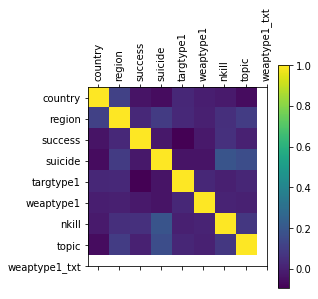

In [17]:
dataset = data[["country","region","success","suicide","targtype1","weaptype1","nkill","topic","weaptype1_txt"]]
dataset = dataset.dropna(axis=0)
weapons = dataset[["weaptype1_txt"]]


plt.matshow(dataset.corr())
plt.xticks(range(len(dataset.columns)), dataset.columns,rotation=90)
plt.yticks(range(len(dataset.columns)), dataset.columns)
plt.colorbar()
plt.show()

target = dataset[["weaptype1"]]
dataset = dataset[["country","region","success","suicide","targtype1","nkill","topic"]]


In [18]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report 


X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size = 0.3, random_state = 100) 

clf = DecisionTreeClassifier(random_state = 100,max_depth=10, min_samples_leaf=5) 
clf.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [19]:
y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.38      0.38         8
           2       0.67      0.03      0.06        60
           3       0.00      0.00      0.00         4
           5       0.62      0.56      0.59      9028
           6       0.71      0.88      0.79     17678
           7       0.00      0.00      0.00         5
           8       0.54      0.25      0.34      1498
           9       0.35      0.01      0.03       616
          10       0.00      0.00      0.00        27
          11       0.00      0.00      0.00        36
          12       0.62      0.19      0.29        27
          13       0.46      0.04      0.08      1928

   micro avg       0.68      0.68      0.68     30915
   macro avg       0.36      0.19      0.21     30915
weighted avg       0.65      0.68      0.64     30915



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


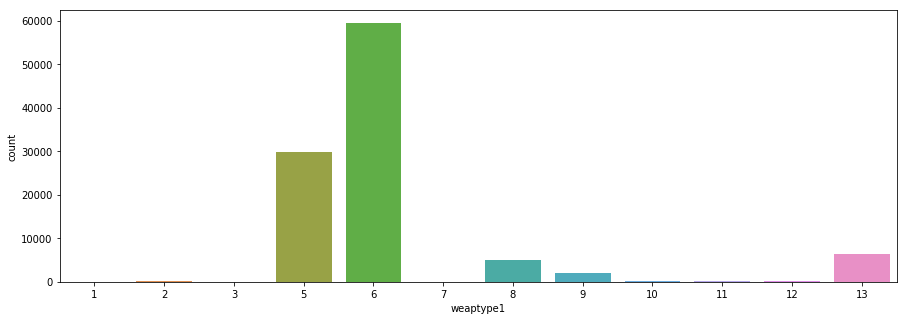

6     59462
5     29931
13     6340
8      4989
9      2075
2       214
10      106
11      100
12       80
1        24
7        13
3        11
Name: weaptype1, dtype: int64


In [20]:
fig = plt.figure(figsize = (15,5))
fig = sns.countplot(data["weaptype1"])
plt.show()
print(data["weaptype1"].value_counts())

In [21]:
model = Word2Vec(pruned_summaries, size=100, window=5, min_count=1, workers=4)

In [22]:
#usa la massima similarity fra le tre parole più alte e la classe da predire come indice per classificare? non ci sono le parole quindi non va 
# e sarebbe honesto o no?
model.similarity("iran","iranian")

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.47350416

In [23]:
l = zip(["a","b"],[1,2])
l = list(l)
print(l)

[('a', 1), ('b', 2)]


In [24]:
s = zip(pruned_summaries,weapons["weaptype1_txt"].tolist())
res = list(s)


In [25]:
similarities = [[model.similarity(s,weap.lower()) for s in summary] for summary,weap in res if weap!="melee"] 

similarities[0]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
E:\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


KeyError: "word 'melee' not in vocabulary"